In [9]:
import numpy as np
from IPython.display import Image

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx

class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

# STEP 7 역전파 자동화
이전 단계에서 역전파를 동작시키는 데 성공했지만, 새로운 계산을 할 때마다 역전파 코드를 직접 작성해야 했다.  
[그림 7-1]처럼 계산 그래프가 여러 개라면 각각의 계산ㄴ에 맞게 역전파 코드를 수동으로 따로따로 작성해야 한다.

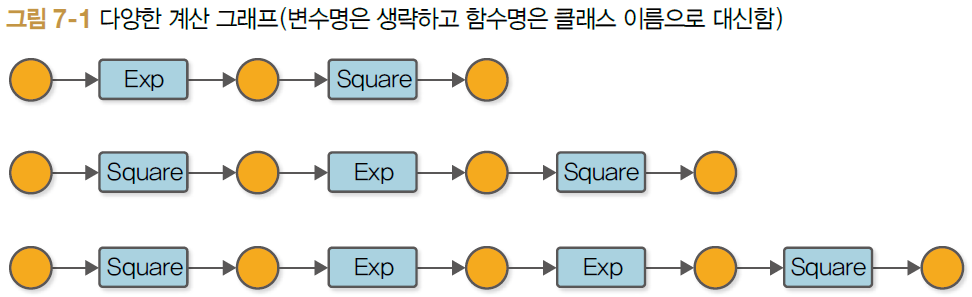

In [10]:
Image("../밑바닥3 그림과 수식/그림 7-1.png")

이제부터 역전파를 자동화하려고 한다.  
더 정확히 말하자면, 순전파를 한 번만 해주면 어떤 계산이라도 상관없이 역전파가 자동으로 이루어지는 구조를 만들 것이다.  
Define-by-Run의 핵심을 건드리는 내용이다!

## 7.1 역전파 자동화의 시작
변수와 함수의 '관계'를 이해하는 데서 출발한다.  
함수 입장에서 변수는 '입력'과 '출력'에 쓰인다.  
변수 입장에서 함수는 '창조자' 혹은 '부모'이다.

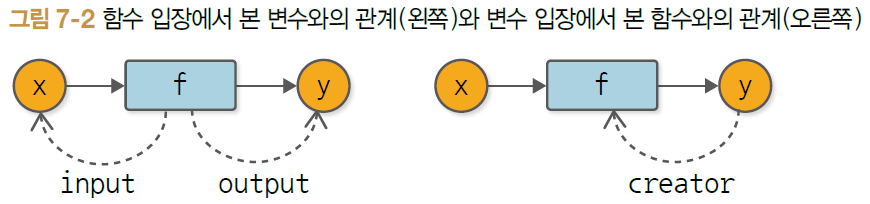

In [11]:
Image("../밑바닥3 그림과 수식/그림 7-2.png")

이러한 관계를 DeZero 코드에 녹여보자.

In [12]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func

In [13]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        output.set_creator(self)  # 출력 변수에 창조자를 설정한다.
        self.input = input
        self.output = output  # 출력도 저장한다.
        return output

순전파를 계산하면 그 결과로 output이라는 Variable 인스턴스가 생성된다.  
이때 생성된 output에 '내가 너의 창조자임'을 기억시킨다.  
이 부분이 연결을 동적으로 만드는 기법의 핵심이다.  
그리고 앞으로를 위해 output을 인스턴스 변수에 저장했다.  
이렇게 연결된 Variable과 Function이 있으면 계산 그래프를 거꾸로 거슬러 올라갈 수 있다.

In [14]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 계산 그래프의 노드들을 거꾸로 거슬러 올라간다.
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x

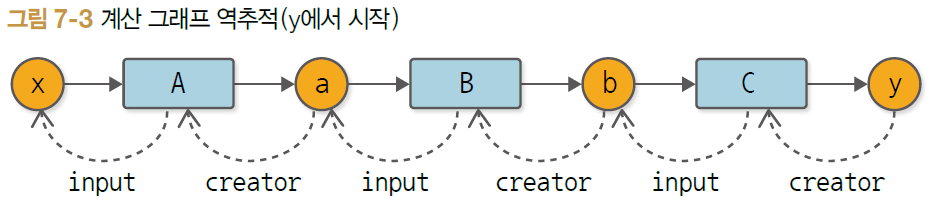

In [15]:
Image("../밑바닥3 그림과 수식/그림 7-3.png")

그림에서 볼 수 있듯이 이러한 '연결'은 순전파 시점에 만들어진다.  
이러한 특성에 이름을 붙인 것이 'Define-by-Run'이다.  
데이터를 흘려보냄(Run)으로써 연결이 정의(Define)된다.  

또한 위 그림을 보면 계산 그래프를 링크드리스트 구조로 표현하고 있는 것을 알 수 있다.

## 7.2 역전파 도전!
변수와 함수의 관계를 이용하여 역전파를 시도해보자.

In [ ]:
y.grad = np.array(1.0)

C = y.creator # 1. 함수를 가져온다.
b = C.input # 2. 함수의 입력을 가져온다.
b.grad = C.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.

## 7.3 backward 메서드 추가

In [3]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        f = self.creator  # 1. Get a function
        if f is not None:
            x = f.input  # 2. Get the function's input
            x.grad = f.backward(self.grad)  # 3. Call the function's backward
            x.backward()

In [8]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# backward
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256
